## TODO

- Run many more sunspots through (potentially change masking algorithm)
- Write save code to do the former without much space
- Super penumbra (50/50/30/30)
- Automate y-lim on plots

In [1]:
from iris_lmsalpy import hcr2fits, extract_irisL2data, saveall as sv
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.cluster import KMeans, MiniBatchKMeans
from ipywidgets import interact

%matplotlib inline

# query_text = 'https://www.lmsal.com/hek/hcr?cmd=search-events3&outputformat=json&startTime=2017-10-25T04:00&stopTime=2017-10-25T05:00&minnumRasterSteps=320&herEvents=SS&hasData=true&limit=200'
# list_urls = hcr2fits.get_fits(query_text)



The provided file is a raster IRIS Level 2 data file.

Extracting information from file iris_l2_20201202_173152_3690108077_raster_t000_r00000.fits... 

Available data with size Y x X x Wavelength are stored in windows labeled as:

--------------------------------------------------------------------
Index --- Window label --- Y x X x WL --- Spectral range [Å] (band)
--------------------------------------------------------------------
  0 	 C II 1336    	   548x320x1025 	   1331.69 - 1358.27  (FUV)
  1 	 Si IV 1394   	   548x320x1023 	   1380.67 - 1406.67  (FUV)
  2 	 Mg II k 2796 	   548x320x1019 	   2783.27 - 2835.11  (NUV)
--------------------------------------------------------------------

Observation description: Very large dense 320-step raster 105.3x175 320s   Deep x 8 Spatial x

Creating temporary file...  /var/folders/wf/ym_jh13s78b0s19mm_rnz_xr0000gn/T/tmpdo9eqntm
Loading joblib file... /Users/aaryan/Documents/Code/LMSAL_HUB/iris_hub/iris_lmsalpy/iris_lmsalpy/NIST_2783_2835_

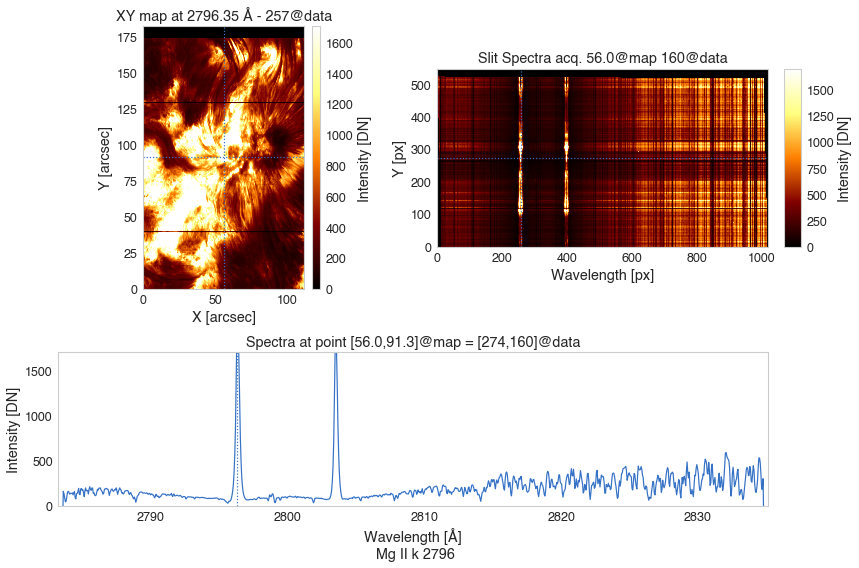

<Figure size 432x288 with 0 Axes>

In [2]:
raster_filename = 'iris_l2_20201202_173152_3690108077_raster_t000_r00000.fits'
iris_raster = extract_irisL2data.load(
    raster_filename, window_info=['Mg II k 2796'], verbose=True
)

iris_raster.quick_look()

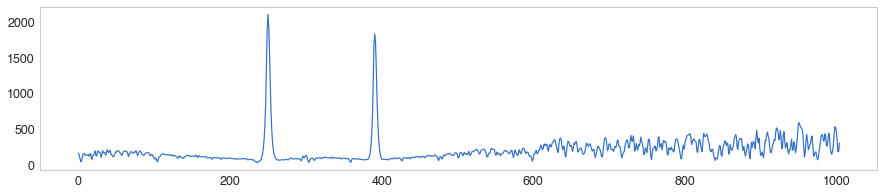

In [3]:
mgii = iris_raster.raster['Mg II k 2796']
s = mgii.data.shape
d = mgii.data[s[0]//2, s[1]//2, :]
d = d[d>0]
best = np.argmin(d)

# 50 -> 31.488714
# 150 -> 321.49338
# log regression with these two vals -- need more data to actually test
climit = -98.4767 + 43.0413 * np.log(mgii.data.mean())

plt.figure(figsize=(15,3))
plt.plot(d)

[0, 524]


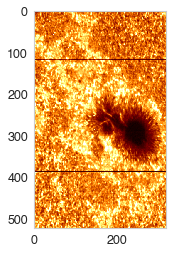

In [4]:
bounds = [0, mgii.data.shape[0]]
for r in range(mgii.data.shape[0]):
    if mgii.data[r].max() != -200:
        bounds[0] = r
        break

for r in range(mgii.data.shape[0]-1, 0, -1):
    if mgii.data[r].max() != -200:
        bounds[1] = r
        break


print(bounds)
data = mgii.data[bounds[0]:bounds[1], :, :]
plt.imshow(data[:, :, best], cmap=mgii.cmap)
plt.clim([0, climit])

In [5]:
import os
import shutil

dir_name = raster_filename[:-5]
if os.path.exists(dir_name):
    shutil.rmtree(dir_name)
os.makedirs(dir_name)

In [6]:
def create_pixels(masked_image):
    pixels = []
    pixels_loc = []
    for i in range(masked_image.shape[0]):
        for j in range(masked_image.shape[1]):
            if masked_image[i,j]:
                d = data[i, j, :]
                pixels.append(d)
                pixels_loc.append((i,j))
    pixels = np.stack(pixels, axis=0)
    pixels_loc = np.array(pixels_loc)
    return (pixels, pixels_loc)

In [7]:
def cluster(pixels, num_clusters):
    mbkm = MiniBatchKMeans(
        n_clusters=num_clusters,
        n_init=10
    )

    y_mbkm = mbkm.fit_predict(pixels)

    km = KMeans(
        n_clusters=num_clusters,
        init=mbkm.cluster_centers_,
        n_init=1
    )

    y_km = km.fit_predict(pixels)
    
    return (km, y_km)

In [8]:
def elbow_kmeans(pixels, num_clusters):
    distortions = []
    for i in range(30, 131, 10):
        km = KMeans(
            n_clusters=num_clusters
        )
        km.fit(pixels)
        distortions.append(km.inertia_)
        print(i, end=' ')

    plt.plot(range(30, 131, 10), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show()

In [9]:
def generate_kmap(km, y_km, pixels_loc, kmap, num_clusters, kmap_sections, section_idx):
    for c in range(num_clusters):
        in_cluster = pixels_loc[y_km==c]
        x,y = zip(*in_cluster)
        # since kmap needs to be same shape as original to overplot
        kmap[np.array(x)+bounds[0],y,:] = km.cluster_centers_[c]
        kmap_sections[np.array(x)+bounds[0],y,:] = section_idx

In [10]:
def sort_clusters_by_size(y_km, num_clusters):
    counts = []
    for i in range(num_clusters):
        counts.append((i, np.count_nonzero(y_km==i)))

    sorted_counts = sorted(counts, key = lambda i: i[1], reverse=True)
    return sorted_counts

In [11]:
def graph_all_clusters(km, y_km, pixels, sorted_counts, num_clusters, 
                       overlay_all=False, ylim=None, filename=None):
    f, axes = plt.subplots(10, num_clusters//10, sharey=True, sharex=True, figsize=(20,20))
    axes = np.ravel(axes)
    for i in range(num_clusters):
        if overlay_all:
            print(i, end=' ')
            for p in pixels[y_km==i]:
                axes[i].plot(p, c='blue', alpha=0.2)

        axes[i].plot(km.cluster_centers_[sorted_counts[i][0]], c='black', lw=2)
        axes[i].set_title('C{} N{}'.format(sorted_counts[i][0], sorted_counts[i][1]))
        
        if ylim:
            axes[i].set_ylim(ylim)
            
    if filename:
        plt.suptitle(filename[:-4], y=0.95)
        plt.savefig(dir_name+'/'+filename)
    
    plt.show()

In [12]:
def interactive_cluster_slider(y_km, km, pixels_loc, masked_image, num_clusters):
    @interact(c=(0, num_clusters-1))
    def double_number(c):
        in_cluster = pixels_loc[y_km==c]
        y,x = zip(*in_cluster)
        f, axes = plt.subplots(1,2,figsize=(12.8,10))
        axes[0].scatter(x,y, s=1, zorder=1)
        axes[0].set_xlim(0, masked_image.shape[1])
        axes[0].set_ylim(masked_image.shape[0], 0)

        implot = axes[0].imshow(data[:, :, best], cmap=mgii.cmap)
        implot.set_clim([0, cl])

        axes[1].plot(km.cluster_centers_[c])

In [63]:
def run_clustering(w, num_clusters, filename, kmap, kmap_sections, section_idx, calc_super):
    masked_image, super_penumbra = clean_image(w, calc_super)
    print('Done masking')
    pixels, pixels_loc = create_pixels(masked_image)
    print('Done creating pixels')
    km, y_km = cluster(pixels, num_clusters)
    print('Done clustering')
#     # elbow_kmeans(pixels, num_clusters)
#     generate_kmap(km, y_km, pixels_loc, kmap, num_clusters, kmap_sections, section_idx)
#     sorted_counts = sort_clusters_by_size(y_km, num_clusters)
#     graph_all_clusters(km, y_km, pixels, sorted_counts, num_clusters, ylim=(0,700), filename=filename)
#     interactive_cluster_slider(y_km, km, pixels_loc, masked_image, num_clusters)
    
    return (masked_image, super_penumbra, km)

In [64]:
def clean_image(w, calc_super):
    ret, masked_image = cv2.threshold(w, 0, 255, cv2.THRESH_BINARY)
    kernel = np.ones((3, 3), np.uint8)
    masked_image = cv2.morphologyEx(masked_image, cv2.MORPH_OPEN, kernel, iterations=1)
    masked_image = cv2.morphologyEx(masked_image, cv2.MORPH_CLOSE, kernel, iterations=1)
    
    super_penumbra = None
    
    if calc_super:
        thresh = masked_image.astype(np.uint8)
        cnts, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
        c = sorted(cnts, key=cv2.contourArea, reverse=True)[0]

        draw = cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB)
        cv2.drawContours(draw, [c], -1, (0,255,0), 2)
        ellipse = cv2.fitEllipse(c)
        center, r, ang = ellipse
        new_ellipse = (center, (r[0]*2, r[1]*2), ang)
        cv2.ellipse(draw,ellipse,(255,0,0),2)
        cv2.ellipse(draw,new_ellipse,(255,0,0),2)

        plt.figure(figsize=(10,10))
        plt.imshow(draw)
        plt.show()
        
        ellipse_mask = np.zeros(thresh.shape).astype(np.uint8)
        contour_mask = np.zeros(thresh.shape).astype(np.uint8)
        
        # -1 thickness causes it to be filled in
        cv2.ellipse(ellipse_mask,new_ellipse,255,-1)
        cv2.drawContours(contour_mask, [c], -1, 255, -1)
        
        super_penumbra = ~contour_mask & ellipse_mask
        
        plt.figure(figsize=(10,10))
        plt.imshow(super_penumbra)
        plt.show()
    
    return (masked_image, super_penumbra)

umbra
Done masking
Done creating pixels
Done clustering
penumbra


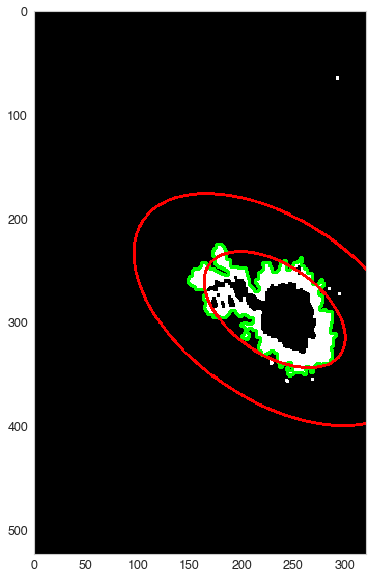

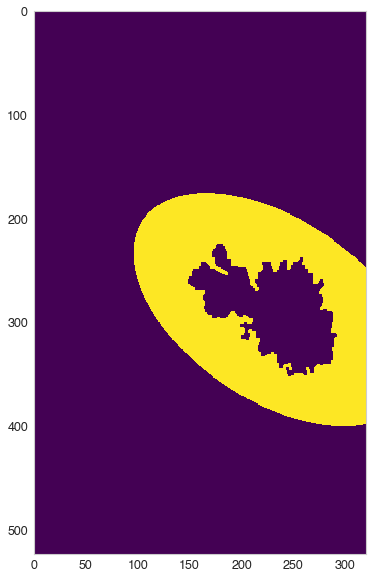

Done masking
Done creating pixels
Done clustering
quiet
Done masking
Done creating pixels


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Done clustering
Saving...
kmap
kmap_sections
all_km


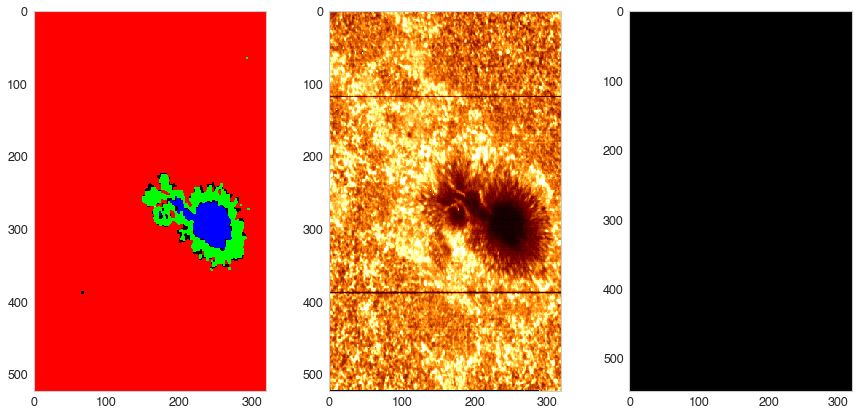

In [65]:
a = data[:, :, best]
m = a.mean()

area_thresholds = [0.25, 0.55]

mask_umbra = a < (m * area_thresholds[0])
mask_penumbra = (a > (m * area_thresholds[0])) & (a < (m * area_thresholds[1]))
mask_quiet = a > m * area_thresholds[1]

cluster_counts = [50, 50, 60]
colors = [(0, 0, 255), (0, 255, 0), (255, 0, 0)]
filenames = ['umbra', 'penumbra', 'quiet']

blank_image = np.zeros(shape=[*a.shape, 3], dtype=np.float32)
kmap = np.zeros(mgii.data.shape)
kmap_sections = np.zeros(shape=[mgii.data.shape[0], mgii.data.shape[1], 1])
kmap_sections.fill(-1)

all_km = []

for i, m in enumerate([mask_umbra, mask_penumbra, mask_quiet]):
    print(filenames[i])
    w = np.where(m, a, 0)
    mask, sp, km = run_clustering(w, cluster_counts[i], filenames[i]+'.png', kmap, kmap_sections, i, filenames[i]=='penumbra')
    rgb = cv2.cvtColor(mask,cv2.COLOR_GRAY2RGB)
    rgb[mask > 0] = colors[i]
    blank_image = cv2.bitwise_or(blank_image, rgb)
    all_km.append(km)

f, axes = plt.subplots(1, 3, figsize=(15,7))
axes[0].imshow(blank_image)
implot = axes[1].imshow(a, cmap=mgii.cmap)
implot.set_clim([0, climit])
kmapplot = axes[2].imshow(kmap[:, :, best], cmap=mgii.cmap)
kmapplot.set_clim([0, climit])
plt.savefig(dir_name + '/segmented.png')

save_filename = dir_name + "/" + 'kmeans_data.jbl.gz'
sv.save(save_filename, kmap, kmap_sections, all_km, force=True)

In [ ]:
del iris_raster, mgii, d